# Generate the heirarchy of morphotopes

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from core.cluster_validation import get_linkage_matrix
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

In [2]:
regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
    regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [3]:
v = "v10"

In [4]:
model_params = "_post_processing_v1"

In [5]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = "/data/uscuni-ulce/processed_data/morphotopes/"

# model_params = '_75_0_None_None_False'


clip = None
to_drop = [
    "stcSAl",
    "stbOri",
    "stcOri",
    "stbCeA",
    "ldkAre",
    "ldkPer",
    "lskCCo",
    "lskERI",
    "lskCWA",
    "ltkOri",
    "ltkWNB",
    "likWBB",
    "likWCe",
    "licBAD",
    "misBAD",
    "ssbCCM",
    "ssbCCD",
]


linkage = "ward"
metric = "euclidean"

morphotope_stat_columns = ["percentile_25", "percentile_75", "mean", "std"]

In [6]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns = component_data.columns.get_level_values(0)

    component_data = component_data[component_data.index.str[-2:] != "-1"]

    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(
        vals, columns=component_data.columns, index=component_data.index
    )
    component_data = component_data.drop(
        component_data.columns[component_data.std() == 0], axis=1
    )

    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(
        vals, columns=component_data.columns, index=component_data.index
    )
    return component_data


def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print("processing", region_id)
    data = pd.read_parquet(
        f"{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq"
    )

    data.index = str(region_id) + "_" + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    if read_extra:
        extra_chars = pd.read_parquet(f"{morphotopes_dir}morph_chars_{region_id}.pq")
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(
            vals, columns=extra_chars.columns, index=extra_chars.index
        ).fillna(0)
        extra_chars = extra_chars.drop(
            component_data.columns[component_data.std() == 0], axis=1
        )
        extra_chars = extra_chars[["limLPS"]]
        extra_chars["limLPS2"] = extra_chars["limLPS"]

        merged_data = pd.merge(
            component_data, extra_chars, how="inner", left_index=True, right_index=True
        )
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data

    return component_data


def get_morphotope_linkage(region_data):
    clusterer = AgglomerativeClustering(
        linkage=linkage, metric=metric, compute_full_tree=True, compute_distances=True
    )
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def read_morphotopes_data(model_params):
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(
            f"{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq"
        )
        region_morphotope_data.index = (
            str(region_id) + "_" + region_morphotope_data.index.str[:]
        )
        data.append(region_morphotope_data)

    data = pd.concat(data)
    return data


def read_morphotopes_chars():
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f"{morphotopes_dir}morph_chars_{region_id}.pq")
        data.append(extra_chars)

    data = pd.concat(data)
    return data


def morphotopes_to_etcs(region_id, etcs=True, model_params="_100_0_None_None_False"):
    if etcs:
        etcs = gpd.read_parquet(
            f"/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet"
        )

    else:
        etcs = gpd.read_parquet(
            f"/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet"
        )

    etcs["label"] = -1

    morphotopes = pd.read_parquet(
        f"/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq"
    )
    morphotopes.loc[:, "morphotope_label"] = morphotopes.values[:, 0]

    morph_dict = pd.Series(
        np.arange(np.unique(morphotopes.values).shape[0]), np.unique(morphotopes.values)
    )
    etcs.loc[morphotopes.index, "label"] = morphotopes.map(
        lambda x: morph_dict.loc[x]
    ).values
    etcs["morph"] = str(region_id) + "_" + "-1"
    etcs.loc[morphotopes.index, "morph"] = str(region_id) + "_" + morphotopes.values
    return etcs

### Direct morphotope hierarchy

In [7]:
%%time
# read morphotopes data
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data[~morphotopes_data.index.str.endswith("-1")]
morphotopes_data = morphotopes_data.iloc[:, :-1]

## drop unwanted columns
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)

CPU times: user 28.4 s, sys: 52.4 s, total: 1min 20s
Wall time: 19.6 s


In [8]:
# add morphotope variables
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[["limLPS", "limAre", "limPer"]]
merged_data = pd.merge(
    component_data, morph_chars_data, how="inner", left_index=True, right_index=True
)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

In [9]:
grouped_data = component_data

In [10]:
## Drop massive outliers
grouped_data = grouped_data.drop(
    grouped_data[
        (grouped_data["limAre"] > 5e5)
        | (grouped_data["limPer"] > 2e5)
        | (grouped_data["ldbPWL"] > 5_000)
        | (grouped_data.sdbAre < 20)
    ].index
)

In [11]:
# drop columns
grouped_data = grouped_data.drop(["ssbCor", "mtdDeg", "limPer", "mtbSWR"], axis=1)

In [12]:
scalar = StandardScaler()
vals = scalar.fit_transform(grouped_data)
vals = np.nan_to_num(vals, 0)
regional_ward_morphotopes_data = pd.DataFrame(
    vals, index=grouped_data.index, columns=grouped_data.columns
)

#### Full linkage with graph

In [13]:
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors._base import _kneighbors_from_graph

In [14]:
n_neighbors = 10

In [15]:
%%time

# generate knn graph
graph = kneighbors_graph(
    regional_ward_morphotopes_data.values,
    n_neighbors=n_neighbors,
    n_jobs=-1,
    include_self=True,
    mode="distance",
)
dists, nns = _kneighbors_from_graph(graph, n_neighbors, return_distance=True)

CPU times: user 22min 23s, sys: 39.4 ms, total: 22min 23s
Wall time: 2min 29s


In [16]:
emgraph = graph
embedding = regional_ward_morphotopes_data

In [17]:
%%time

linkage = "ward"
metric = "euclidean"

clusterer = AgglomerativeClustering(
    linkage=linkage,
    metric=metric,
    connectivity=emgraph,
    compute_full_tree=True,
    compute_distances=True,
)
clusterer.fit(embedding)

CPU times: user 2min 17s, sys: 1.09 s, total: 2min 18s
Wall time: 2min 18s


AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5639660 stored elements and shape (563966, 563966)>)

In [18]:
linkage_matrix = get_linkage_matrix(clusterer)

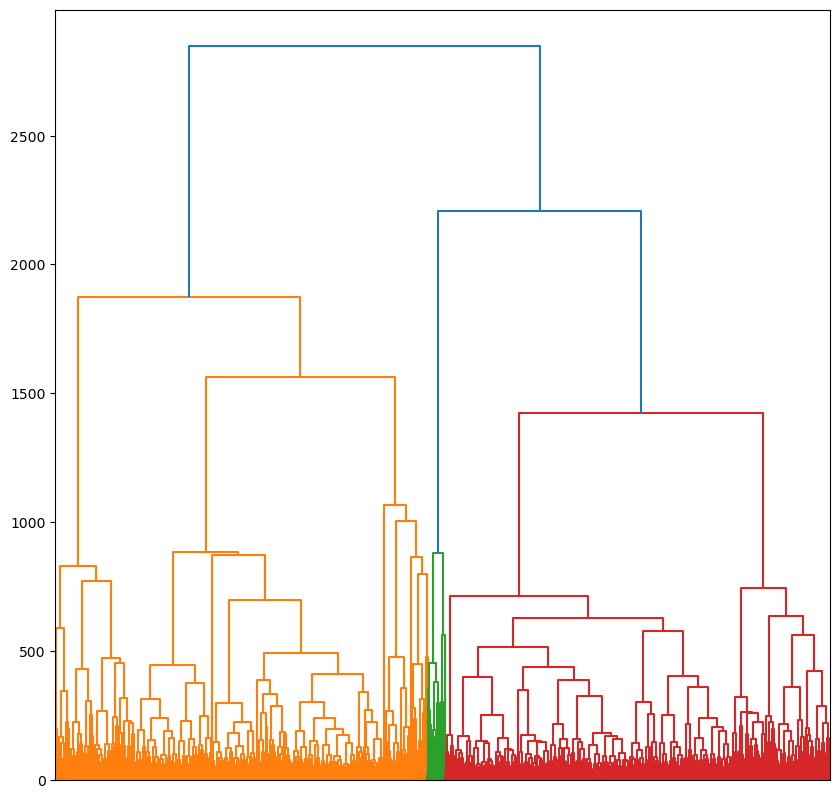

In [19]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig, ax = plt.subplots(figsize=(10, 10))
_ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

## Save data

In [98]:
# potentially pick a new cutoff
final_cutoff = 200
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion="distance")
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

99    21156
60    20065
97    18391
93    18110
57    17796
      ...  
45        3
61        3
11        2
8         1
46        1
Name: count, Length: 110, dtype: int64

In [99]:
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,389.775612,94.278728,0.0,0.413456,0.358902,0.996464,0.456751,0.0,126.454408,0.894444,...,0.447964,0.943948,0.363889,48.216476,4.497810,4.497810,414.397558,350.350963,1.0,29202.268591
2,172.979938,58.750544,0.0,0.502542,0.384315,0.992234,0.585859,0.0,198.151437,0.600000,...,0.541369,0.738082,0.342873,66.538592,4.943476,4.943476,305.969256,289.735117,1.0,27760.053069
3,219.189543,67.110053,0.0,0.469869,0.353383,0.996027,0.529649,0.0,112.211980,0.800000,...,0.486252,0.915885,0.378657,41.749682,4.114390,4.114390,285.887493,254.066749,1.0,22403.023698
4,171.358009,58.717412,0.0,0.504157,0.290004,0.999439,0.570796,0.0,85.207061,0.857143,...,0.561674,0.962147,0.456233,31.256400,3.651711,3.651711,327.894679,355.550488,1.0,25178.278855
5,132.275873,49.850914,0.0,0.522749,0.278087,0.998933,0.602886,0.0,107.246249,0.666667,...,0.476896,0.899474,0.365204,38.776006,3.739775,3.739775,146.019319,145.578671,1.0,13644.267952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,118.614305,47.702926,0.0,0.516041,0.916570,0.984577,0.638489,0.0,142.278105,0.600000,...,0.571173,0.726973,0.359988,46.232415,3.846917,3.846917,120.394837,123.528863,1.0,13285.761283
107,106.080259,45.704076,0.0,0.503791,0.804553,0.962605,0.639918,0.0,86.249212,0.750000,...,0.623504,0.827653,0.419443,28.889564,3.026651,3.026651,88.610366,95.751749,1.0,7997.640197
108,84.172947,39.892146,0.0,0.515850,1.874149,0.993128,0.639257,0.0,277.742634,0.428571,...,0.597542,0.481689,0.318741,69.422605,3.715541,3.715541,72.548363,81.146540,1.0,11793.210673
109,67.555383,35.490564,0.0,0.529719,1.328450,0.997165,0.655040,0.0,145.082231,0.500000,...,0.605087,0.635177,0.358224,43.009784,3.209901,3.209901,57.489866,65.374153,1.0,7259.397151


In [100]:
normalised_cdata = (
    regional_ward_morphotopes_data.groupby(final_clusters).median().fillna(0)
)
normalised_cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,6.255669,5.345239,-0.003262,-3.762805,-0.107379,0.290795,-2.802041,-0.08234,0.407508,0.675988,...,-1.790308,0.381238,-1.275208,0.897099,2.072793,2.072793,1.758428,1.002527,0.149898,1.550460
2,1.782032,1.903554,-0.003262,-1.247260,-0.083456,0.056274,-1.181185,-0.08234,1.085489,-1.178078,...,-0.950272,-1.211791,-1.513599,1.667060,2.637254,2.637254,1.167455,0.744195,0.149898,1.444593
3,2.735579,2.713356,-0.003262,-2.169857,-0.112575,0.266555,-1.886855,-0.08234,0.272829,0.081287,...,-1.445961,0.164082,-1.107694,0.625341,1.587169,1.587169,1.058002,0.592183,0.149898,1.051358
4,1.748563,1.900345,-0.003262,-1.201671,-0.172238,0.455709,-1.370286,-0.08234,0.017465,0.441106,...,-0.767658,0.522065,-0.227736,0.184376,1.001159,1.001159,1.286956,1.024687,0.149898,1.255077
5,0.942092,1.041430,-0.003262,-0.676668,-0.183457,0.427660,-0.967416,-0.08234,0.225872,-0.758289,...,-1.530102,0.037091,-1.260293,0.500377,1.112697,1.112697,0.295671,0.129828,0.149898,0.408417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.660182,0.833350,-0.003262,-0.866095,0.417594,-0.368178,-0.520452,-0.08234,0.557140,-1.178078,...,-0.682233,-1.297749,-1.319461,0.813722,1.248399,1.248399,0.156008,0.035856,0.149898,0.382101
107,0.401539,0.639717,-0.003262,-1.211998,0.312144,-1.586140,-0.502509,-0.08234,0.027320,-0.233554,...,-0.211588,-0.518672,-0.645051,0.084913,0.209484,0.209484,-0.017228,-0.082525,0.149898,-0.006076
108,-0.050525,0.076704,-0.003262,-0.871495,1.319033,0.105856,-0.510806,-0.08234,1.838118,-2.257534,...,-0.445077,-3.195808,-1.787337,1.788257,1.082003,1.082003,-0.104772,-0.144769,0.149898,0.272540
109,-0.393432,-0.349686,-0.003262,-0.479861,0.805327,0.329648,-0.312669,-0.08234,0.583656,-1.807760,...,-0.377224,-2.008086,-1.339478,0.678295,0.441581,0.441581,-0.186846,-0.211988,0.149898,-0.060267


In [104]:
# regional_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/regional_clusters_{v}.pq')

In [105]:
final_clusters.to_frame().to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq"
)

In [106]:
cdata.to_parquet(f"/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq")

In [107]:
normalised_cdata.to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/normalised_cdata_{v}.pq"
)

In [108]:
regional_ward_morphotopes_data.to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq"
)

In [109]:
np.save(
    f"/data/uscuni-ulce/processed_data/clusters/complete_linkage_{n_neighbors}_{v}.npy",
    linkage_matrix,
)

# Create mapping

In [ ]:
## hierarchical cutoff

cutoffs = [200, 300, 500, 700, 1000, 1600, 2500]

cluster_frame = []
for c in reversed(cutoffs):
    clusters = fcluster(linkage_matrix, t=c, criterion="distance")
    cluster_frame.append(pd.Series(clusters, regional_ward_morphotopes_data.index))
cluster_frame = pd.concat(cluster_frame, axis=1)
cluster_frame.columns = cluster_frame.columns + 1

cluster_frame.drop_duplicates().set_index(7).sort_index().to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

## Assign clusters to ETCs in all regions

In [113]:
v = "v10"
merged_clusters = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq"
)[0]
merged_clusters.nunique()

110

In [115]:
%%time

# morphotope code
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs["final"] = etcs["morph"].map(
        lambda x: final_clusters.loc[x]
        if x in regional_ward_morphotopes_data.index
        else -1
    )
    etcs.to_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
    )

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


# Analyse splits

In [13]:
linkage_matrix = np.load(
    f"/data/uscuni-ulce/processed_data/clusters/complete_linkage_10_v10.npy"
)

In [16]:
def analyze_hierarchical_splits(linkage_matrix, df, top_n_splits=None):
    """
    Traverses a SciPy linkage tree from the top down and computes the
    feature differences between the left and right branches at each split.

    Args:
        linkage_matrix: The output from scipy.cluster.hierarchy.linkage
        df (pd.DataFrame): The standardized dataframe used to generate the linkage.
        top_n_splits (int, optional): If set, stops after analyzing this many splits
                                      (breadth-first). Useful for large trees.

    Returns:
        pd.DataFrame: A record of splits with feature importances.
    """

    from scipy.cluster.hierarchy import linkage, to_tree

    # Convert linkage to a tree object for easy traversal
    # root_node represents the single cluster containing all points
    root_node = to_tree(linkage_matrix)
    
    # We will use a list to store our analysis of each node
    split_analysis = []
    
    # Queue for Breadth-First Search (starts at root)
    # Tuple format: (Node Object, Tree Depth)
    queue = [(root_node, 0)]
    
    # Counter for splits processed
    splits_processed = 0
    
    while queue:
        current_node, depth = queue.pop(0)
        
        # If the node is a leaf (original data point), it cannot be split
        if current_node.is_leaf():
            continue
            
        # Get left and right children
        left_child = current_node.get_left()
        right_child = current_node.get_right()
        
        # Get the indices of the original dataframe for both sides
        # pre_order() returns the list of leaf indices under a node
        left_indices = left_child.pre_order()
        right_indices = right_child.pre_order()
        
        # Extract the actual data
        left_data = df.iloc[left_indices]
        right_data = df.iloc[right_indices]
        
        # --- COMPUTE RELATIVE EFFECT ---
        # Since data is standardized, the difference in means (centroids) 
        # is a robust measure of "feature importance" for this specific split.
        left_mean = left_data.mean(axis=0)
        right_mean = right_data.mean(axis=0)
        
        # Difference vector: High positive values mean Left > Right
        # High negative values mean Right > Left
        diff_vector = left_mean - right_mean
        
        # Calculate a "Importance Score" (Magnitude of the difference)
        importance_score = diff_vector.abs().sort_values(ascending=False)
        
        # Store results
        split_info = {
            'Node_ID': current_node.id,
            'Depth': depth,
            'Left_Count': len(left_indices),
            'Right_Count': len(right_indices),
            'Primary_Driver': importance_score.index[0], # Feature with biggest diff
            'Driver_Score': importance_score.iloc[0],    # Magnitude of diff
            **diff_vector.to_dict() # Unpack all feature differences
        }
        split_analysis.append(split_info)
        
        # Add children to queue to continue traversing down
        queue.append((left_child, depth + 1))
        queue.append((right_child, depth + 1))
        
        splits_processed += 1
        if top_n_splits and splits_processed >= top_n_splits:
            break
            
    # Convert to DataFrame for easy viewing
    results_df = pd.DataFrame(split_analysis)
    
    # Reorder columns to put metadata first
    cols = ['Node_ID', 'Depth', 'Left_Count', 'Right_Count', 'Primary_Driver', 'Driver_Score'] 
    feature_cols = [c for c in results_df.columns if c not in cols]
    results_df = results_df[cols + feature_cols]
    
    return results_df

In [34]:
analysis_df = analyze_hierarchical_splits(linkage_matrix, regional_ward_morphotopes_data, 1000)

In [35]:
analysis_df

,Node_ID,Depth,Left_Count,Right_Count,Primary_Driver,Driver_Score,sdbAre,sdbPer,sdbCoA,ssbCCo,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
0,1038516,0,217236,302023,sdsSPO,1.468167,0.653906,0.689239,-5.608777e-03,-0.228576,...,0.031251,0.728864,0.495558,-0.311760,-0.066956,-0.066956,0.307075,0.372117,-3.543055e-01,0.340860
1,1038514,1,32412,184824,limAre,2.449703,1.720644,1.663435,-4.336809e-19,-1.288235,...,-1.014288,-0.500704,-1.084097,1.000345,1.982200,1.982200,1.922439,1.639208,-2.362376e+00,2.449703
2,1038515,1,10007,292016,mibLen,5.366948,1.627239,1.698577,1.692795e-01,-1.323767,...,-0.830539,-3.853226,-2.222319,5.084199,2.834603,2.834603,0.534214,0.355652,-9.551343e-03,1.524039
3,1038510,2,21052,11360,limLPS,6.744714,0.477533,0.481937,0.000000e+00,-0.562729,...,-0.757802,-0.125255,-0.724587,0.058091,-0.368298,-0.368298,-1.962285,-2.227618,6.744714e+00,-2.977333
4,1038513,2,27304,157520,sdsLen,2.560378,0.047330,0.059347,0.000000e+00,-0.454481,...,-0.503639,0.073102,-0.253348,0.022151,-0.026380,-0.026380,-0.050470,0.087837,-1.230116e-02,-0.057721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1033273,10,17,39,midRea,2.099308,0.025885,0.056166,-1.301043e-18,-0.190199,...,-0.453652,0.115059,0.161280,-0.093768,-0.156467,-0.156467,-0.129429,-0.271009,-2.775558e-17,-0.156161
996,1036532,10,6,78,midBAD,9.206786,0.067391,0.062902,0.000000e+00,0.493425,...,0.899687,-0.429595,0.117518,0.211167,0.419450,0.419450,0.020738,9.206786,0.000000e+00,0.485298
997,1036179,10,20,28,sdsAre,2.818602,-0.706867,-0.837417,-8.673617e-19,1.335242,...,1.405480,-0.015517,0.865563,-0.224227,-0.618875,-0.618875,-0.180924,-0.050769,2.775558e-17,-0.245424
998,1036844,10,36,88,midAre,3.671231,-0.094662,-0.108039,8.673617e-19,0.133081,...,0.034523,-0.140924,-0.130869,0.043278,0.044387,0.044387,0.030645,0.046797,5.551115e-17,0.007472


In [29]:
def count_top_features_from_analysis(split_analysis_df, top_k=10):
    """
    Takes the detailed split analysis DataFrame, identifies the top K features 
    for each split (row) based on absolute magnitude, and aggregates their 
    frequency across the entire tree.

    Args:
        split_analysis_df (pd.DataFrame): Output from analyze_hierarchical_splits.
        top_k (int): How many top features to consider per split.

    Returns:
        pd.DataFrame: A DataFrame with 'Feature' and 'Count', sorted by Count.
    """
    # 1. Define metadata columns to exclude so we isolate the feature columns
    metadata_cols = {'Node_ID', 'Depth', 'Left_Count', 'Right_Count', 
                     'Primary_Driver', 'Driver_Score'}
    
    # Identify feature columns dynamically
    feature_cols = [c for c in split_analysis_df.columns if c not in metadata_cols]
    
    if not feature_cols:
        raise ValueError("No feature columns found in the input DataFrame.")

    # 2. Extract feature data, take absolute value (magnitude of difference)
    #    The sign (+/-) indicates direction, but importance is magnitude.
    feature_data_abs = split_analysis_df[feature_cols].abs()

    # 3. For each row (split), find the names of the top K features
    #    stack() creates a MultiIndex series, we then group by the original index (level 0)
    #    and grab the top K largest values.
    
    # Efficient method using numpy for speed if data is large, 
    # but pandas apply is clearer for standard usage:
    top_features_per_split = feature_data_abs.apply(
        lambda row: row.nlargest(top_k).index.tolist(), 
        axis=1
    )

    # 4. Flatten the list of lists into a single list of all top features found
    all_top_features = [feat for sublist in top_features_per_split for feat in sublist]

    # 5. Count occurrences
    counts = pd.Series(all_top_features).value_counts()

    # 6. Format the output DataFrame
    counts_df = counts.to_frame(name='Count')
    counts_df.index.name = 'Feature'
    counts_df.reset_index(inplace=True)
    
    return counts_df

In [36]:
freq = count_top_features_from_analysis(analysis_df)

In [37]:
freq.to_csv("../data/split_frequencies.csv")